INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0c0u9ppp/ltx3hq7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0c0u9ppp/jdoml5a6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38664', 'data', 'file=/tmp/tmp0c0u9ppp/ltx3hq7t.json', 'init=/tmp/tmp0c0u9ppp/jdoml5a6.json', 'output', 'file=/tmp/tmp0c0u9ppp/prophet_modelujwd1z40/prophet_model-20250818161630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:16:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


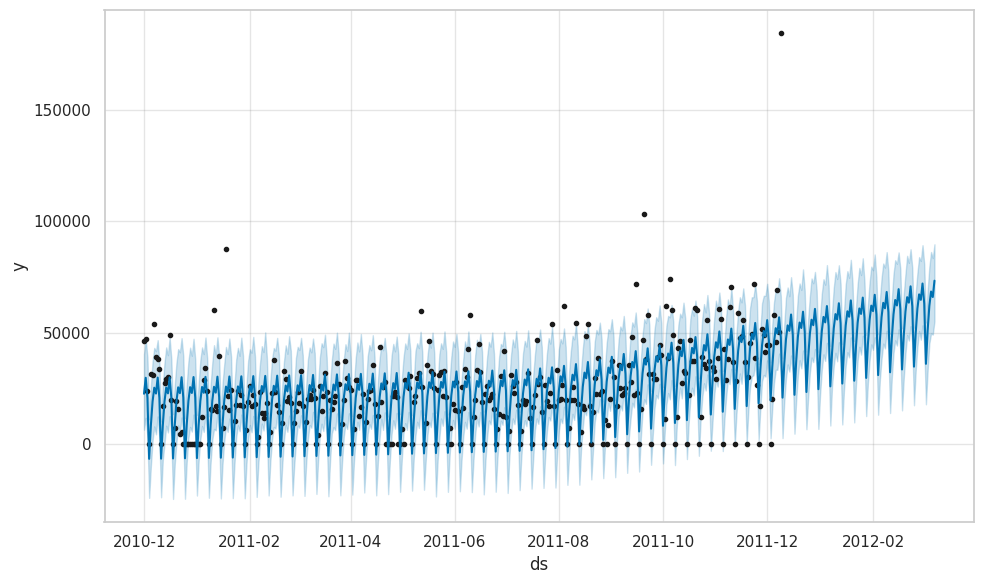

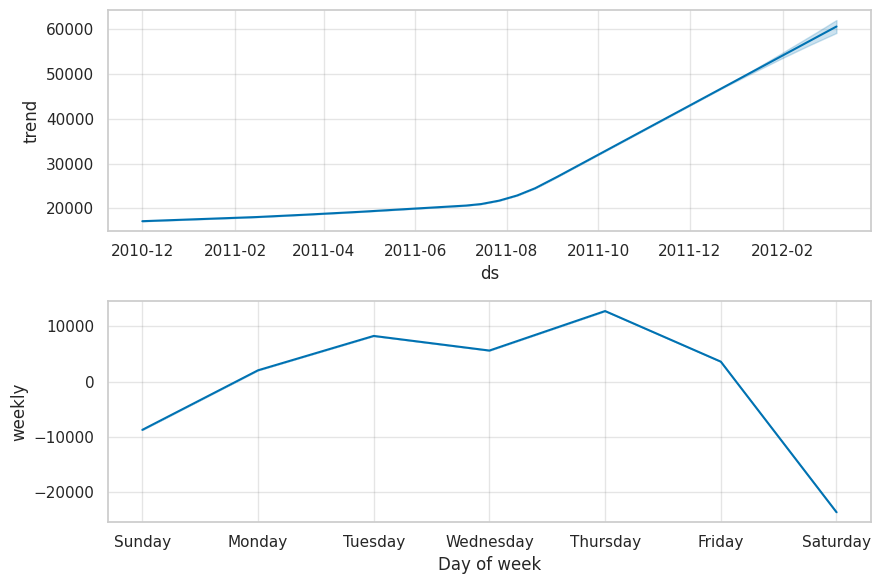

In [16]:
!pip install prophet

from prophet import Prophet

# Prepare data
df_prophet = daily_revenue.reset_index()
df_prophet.columns = ["ds", "y"]

# Train model
model = Prophet()
model.fit(df_prophet)

# Forecast future (next 90 days)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.show()

# Plot seasonality components
fig2 = model.plot_components(forecast)
plt.show()

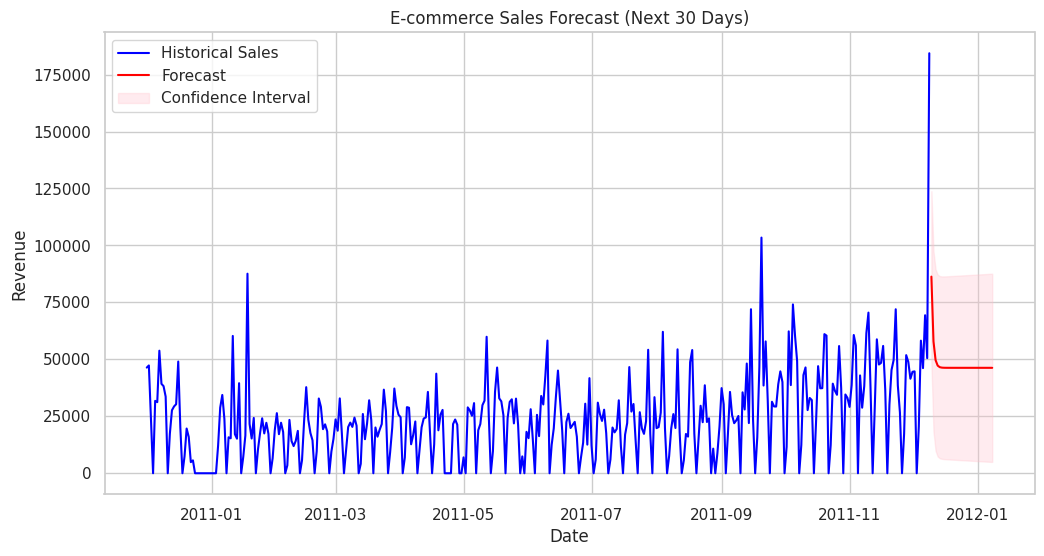

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 1: Prepare daily revenue time series
daily_revenue = df.groupby("InvoiceDate")["TotalPrice"].sum().resample("D").sum()

# Step 2: Fit ARIMA model (manual order example: (1,1,1))
model = sm.tsa.ARIMA(daily_revenue, order=(1,1,1))
results = model.fit()

# Step 3: Forecast next 30 days
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)

forecast_index = pd.date_range(
    start=daily_revenue.index[-1] + pd.Timedelta(days=1),
    periods=forecast_steps
)

# Step 4: Plot actuals + forecast
plt.figure(figsize=(12,6))
plt.plot(daily_revenue, label="Historical Sales", color="blue")
plt.plot(forecast_index, forecast.predicted_mean, label="Forecast", color="red")
plt.fill_between(
    forecast_index,
    forecast.conf_int()["lower TotalPrice"],
    forecast.conf_int()["upper TotalPrice"],
    color="pink", alpha=0.3, label="Confidence Interval"
)
plt.title("E-commerce Sales Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()

In [10]:
!pip install mlxtend

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Prepare Basket Data (UK transactions only to simplify)
basket = (df[df['Country'] == "United Kingdom"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Step 2: Convert to Binary (0 = not purchased, 1 = purchased)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Step 3: Find Frequent Itemsets using Apriori
frequent_items = apriori(basket, min_support=0.02, use_colnames=True)

# Step 4: Generate Association Rules
rules = association_rules(frequent_items, metric="lift", min_threshold=1)

# Step 5: Sort and Display Top Rules
rules = rules.sort_values("lift", ascending=False)
print(rules.head(10))

/tmp/ipython-input-87472451.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                                          antecedents  \
71  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
74                  (GREEN REGENCY TEACUP AND SAUCER)   
75                   (PINK REGENCY TEACUP AND SAUCER)   
70  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
4                   (GREEN REGENCY TEACUP AND SAUCER)   
5                    (PINK REGENCY TEACUP AND SAUCER)   
72  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
73                 (ROSES REGENCY TEACUP AND SAUCER )   
7                   (GREEN REGENCY TEACUP AND SAUCER)   
6                  (ROSES REGENCY TEACUP AND SAUCER )   

                                          consequents  antecedent support  \
71                  (GREEN REGENCY TEACUP AND SAUCER)            0.023009   
74  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...            0.036766   
75  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...            0.029617   
70                   (PINK REGENCY TEACUP AND SAUCER)           

In [9]:
import pandas as pd

# Step 1: Calculate RFM metrics
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (df["InvoiceDate"].max() - x.max()).days,  # Recency
    "InvoiceNo": "nunique",  # Frequency
    "TotalPrice": "sum"  # Monetary
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

# Step 2: Assign R, F, M scores (1–5 scale)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)  # Recent → higher score
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

# Step 3: Combine RFM score
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].sum(axis=1)

# Step 4: Define customer groups
rfm["Customer_Type"] = "Others"
rfm.loc[rfm["RFM_Score"] >= 12, "Customer_Type"] = "Champions"
rfm.loc[(rfm["RFM_Score"] >= 9) & (rfm["RFM_Score"] < 12), "Customer_Type"] = "Loyal Customers"
rfm.loc[(rfm["RFM_Score"] >= 6) & (rfm["RFM_Score"] < 9), "Customer_Type"] = "Potential Loyalist"
rfm.loc[rfm["RFM_Score"] < 6, "Customer_Type"] = "At Risk"

# Step 5: Preview result
print(rfm.head())

            Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
CustomerID                                                            
12346.0         325          1  77183.60        1        1        5   
12347.0           1          7   4310.00        5        5        5   
12348.0          74          4   1797.24        2        4        4   
12349.0          18          1   1757.55        4        1        4   
12350.0         309          1    334.40        1        1        2   

           RFM_Segment  RFM_Score       Customer_Type  
CustomerID                                             
12346.0            115          7  Potential Loyalist  
12347.0            555         15           Champions  
12348.0            244         10     Loyal Customers  
12349.0            414          9     Loyal Customers  
12350.0            112          4             At Risk  


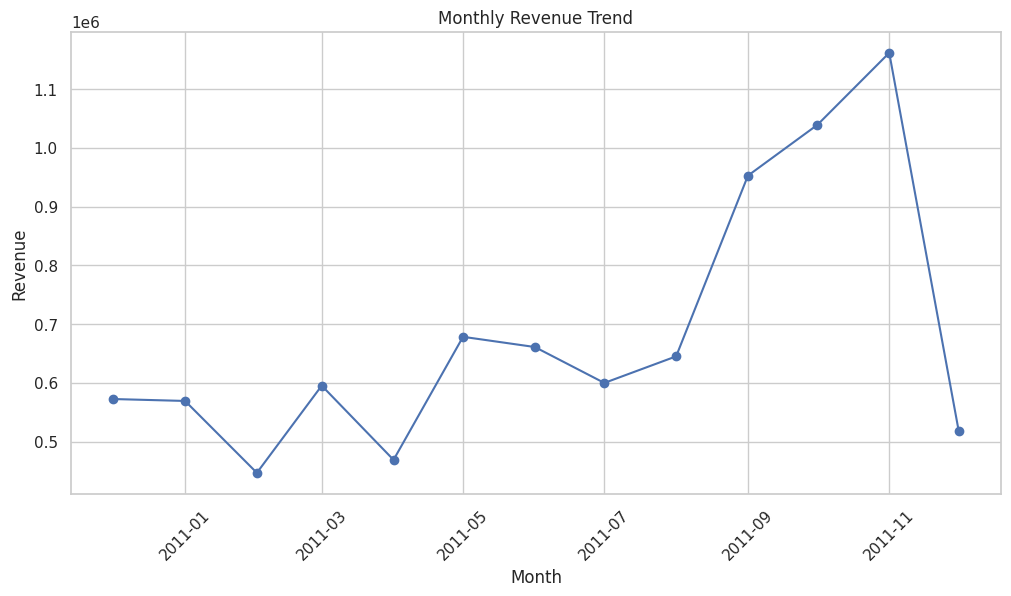

/tmp/ipython-input-2151075148.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


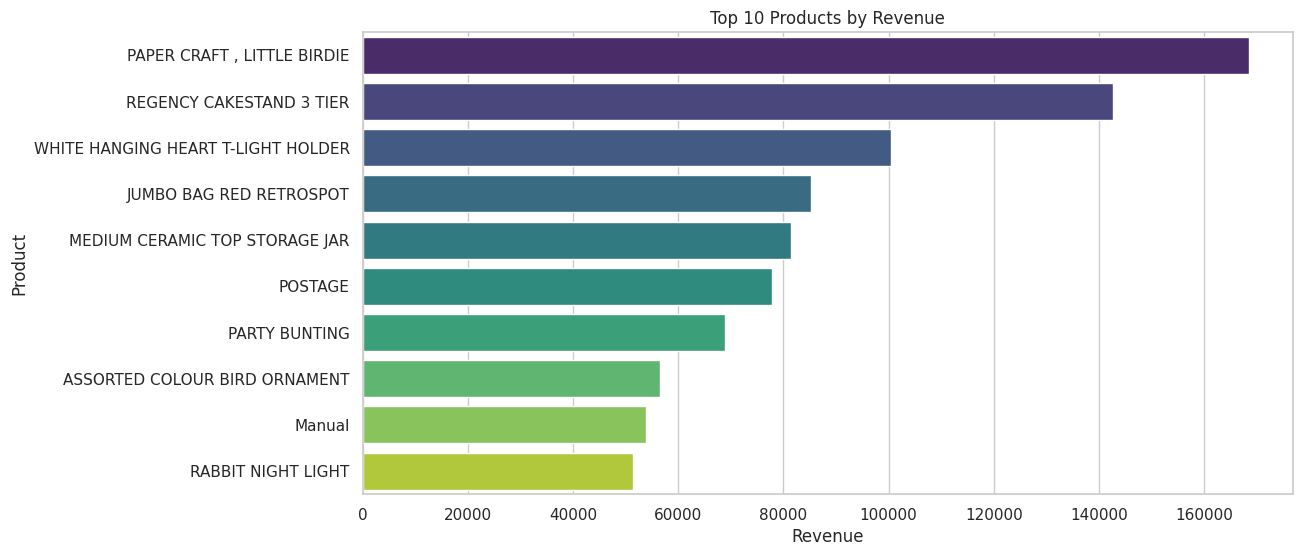

/tmp/ipython-input-2151075148.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_customers.index.astype(str), y=top_customers.values, palette="magma")


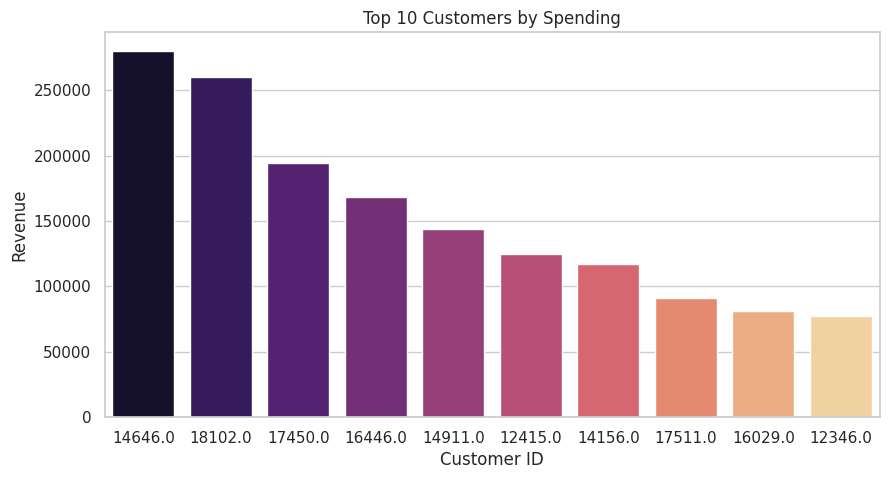

/tmp/ipython-input-2151075148.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="cubehelix")


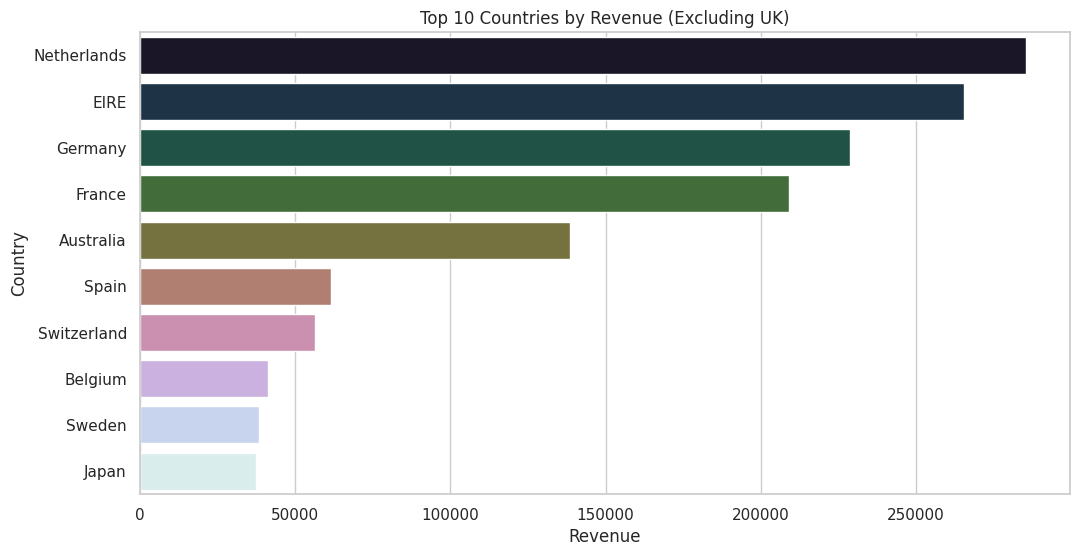

/tmp/ipython-input-2151075148.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_by_day.index, y=orders_by_day.values, palette="coolwarm")


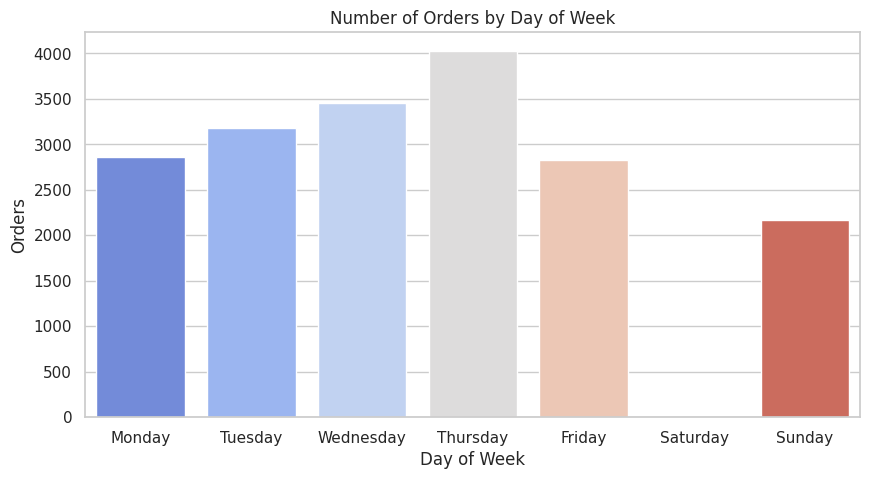

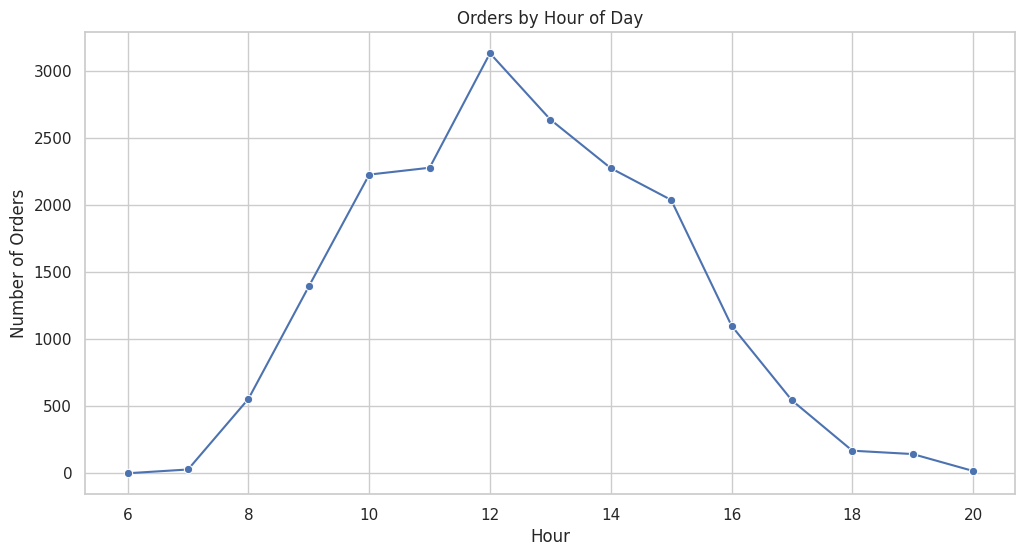

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# ----------------------------
# 1. Monthly Revenue Trend
# ----------------------------
monthly_sales = df.groupby(["Year", "Month"])["TotalPrice"].sum().reset_index()
monthly_sales["YearMonth"] = pd.to_datetime(monthly_sales["Year"].astype(str) + "-" + monthly_sales["Month"].astype(str) + "-01")

plt.figure(figsize=(12,6))
plt.plot(monthly_sales["YearMonth"], monthly_sales["TotalPrice"], marker="o")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

# ----------------------------
# 2. Top 10 Products by Revenue
# ----------------------------
top_products = df.groupby("Description")["TotalPrice"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.show()

# ----------------------------
# 3. Top 10 Customers by Spending
# ----------------------------
top_customers = df.groupby("CustomerID")["TotalPrice"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_customers.index.astype(str), y=top_customers.values, palette="magma")
plt.title("Top 10 Customers by Spending")
plt.xlabel("Customer ID")
plt.ylabel("Revenue")
plt.show()

# ----------------------------
# 4. Revenue by Country (Top 10 excluding UK)
# ----------------------------
country_sales = df.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False)
top_countries = country_sales.drop("United Kingdom").head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="cubehelix")
plt.title("Top 10 Countries by Revenue (Excluding UK)")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.show()

# ----------------------------
# 5. Orders by Day of Week
# ----------------------------
orders_by_day = df.groupby("DayOfWeek")["InvoiceNo"].nunique().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(10,5))
sns.barplot(x=orders_by_day.index, y=orders_by_day.values, palette="coolwarm")
plt.title("Number of Orders by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Orders")
plt.show()

# ----------------------------
# 6. Orders by Hour of Day
# ----------------------------
orders_by_hour = df.groupby("Hour")["InvoiceNo"].nunique()

plt.figure(figsize=(12,6))
sns.lineplot(x=orders_by_hour.index, y=orders_by_hour.values, marker="o")
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Orders")
plt.show()

In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np

# Step 2: Load dataset
# (update path if needed, e.g., "Ecommerce.csv")
df = pd.read_csv("/content/data.csv", encoding='ISO-8859-1')

# Step 3: Quick look at data
print(df.shape)
print(df.head())
print(df.info())

# Step 4: Handle missing values
# Check missing values
print(df.isnull().sum())

# Remove rows with missing CustomerID (cannot be used for customer analysis)
df = df.dropna(subset=["CustomerID"])

# Step 5: Remove canceled/refunded orders
# Invoice numbers starting with "C" = cancellations
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Step 6: Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Step 7: Create new columns
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]  # Revenue column
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()
df["Hour"] = df["InvoiceDate"].dt.hour

# Step 8: Remove negative or zero values
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Step 9: Final check
print(df.describe())
print(df.head())

# Save cleaned data (optional)
df.to_csv("cleaned_ecommerce.csv", index=False)

(541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   

In [6]:
print("Unique values in Frequency column:")
print(rfm["Frequency"].value_counts().sort_index())

print("\nUnique values in Monetary column (first 20):")
print(rfm["Monetary"].value_counts().sort_index().head(20))

Unique values in Frequency column:
Frequency
1      1493
2       835
3       508
4       388
5       242
6       172
7       143
8        98
9        68
10       54
11       52
12       45
13       30
14       20
15       28
16       11
17       18
18       14
19       12
20       12
21       11
22        5
23        5
24        3
25        8
26        7
27        3
28        6
29        1
30        4
31        3
32        3
33        2
34        3
35        1
37        3
38        2
39        2
41        1
44        1
45        1
46        1
47        2
48        1
50        1
51        1
55        2
57        1
60        1
62        1
63        1
73        1
86        1
91        1
93        1
97        1
124       1
201       1
209       1
Name: count, dtype: int64

Unique values in Monetary column (first 20):
Monetary
3.75     1
6.20     1
6.90     1
12.75    1
13.30    1
15.00    3
17.00    1
20.80    2
25.50    2
30.00    1
30.60    1
32.65    1
34.00    1
34.80    1
35.40    3
3